In [176]:

import numpy as np # library to handle data in a vectorized manner

import pandas as pd
import requests
from bs4 import BeautifulSoup
! pip install folium
import folium
import json # library to handle JSON files
!pip install geopy
#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

In [98]:
#get the content from wikipedia
url="https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"
data=requests.get(url).text

In [99]:
soup=BeautifulSoup(data,'html5lib')
table=soup.find('table')
table

<table cellpadding="2" cellspacing="0" rules="all" style="width:100%;">

<tbody><tr>
<td style="width:11%;">
<p>M1A<br/><span style="font-size:85%;">Not assigned</span>
</p>
</td>
<td style="width:11%;">
<p>M2A<br/><span style="font-size:85%;">Not assigned</span>
</p>
</td>
<td style="width:11%;">
<p>M3A<br/><span style="font-size:85%;"><a href="/wiki/North_York" title="North York">North York</a><br/>(<a href="/wiki/Parkwoods" title="Parkwoods">Parkwoods</a>)</span>
</p>
</td>
<td style="width:11%;">
<p>M4A<br/><span style="font-size:85%;"><a href="/wiki/North_York" title="North York">North York</a><br/>(<a href="/wiki/Victoria_Village" title="Victoria Village">Victoria Village</a>)</span>
</p>
</td>
<td style="width:11%;">
<p>M5A<br/><span style="font-size:85%;"><a href="/wiki/Downtown_Toronto" title="Downtown Toronto">Downtown Toronto</a><br/>(<a href="/wiki/Regent_Park" title="Regent Park">Regent Park</a> / <a href="/wiki/Harbourfront,_Toronto" title="Harbourfront, Toronto">Harbourf

### Convert the web data to a dataframe

In [100]:



table_contents=[]

for row in table.findAll('td'):
    cell = {}
    if row.span.text=='Not assigned':
        pass
    else:
        cell['PostalCode'] = row.p.text[:3]
        cell['Borough'] = (row.span.text).split('(')[0]
        cell['Neighborhood'] = (((((row.span.text).split('(')[1]).strip(')')).replace(' /',',')).replace(')',' ')).strip(' ')
        table_contents.append(cell)

# print(table_contents)
df=pd.DataFrame(table_contents)
df['Borough']=df['Borough'].replace({'Downtown TorontoStn A PO Boxes25 The Esplanade':'Downtown Toronto Stn A',
                                             'East TorontoBusiness reply mail Processing Centre969 Eastern':'East Toronto Business',
                                             'EtobicokeNorthwest':'Etobicoke Northwest','East YorkEast Toronto':'East York/East Toronto',
                                             'MississaugaCanada Post Gateway Processing Centre':'Mississauga'})

In [101]:
df.head()

,PostalCode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Queen's Park,Ontario Provincial Government


In [102]:
df.shape

(103, 3)

### Import coordinates data

In [103]:
# The code was removed by Watson Studio for sharing.

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


### Merge the cooridators witht the Toronto neighborhood

In [104]:
df2 = pd.merge(left=df, right=df1, how='left', left_on='PostalCode', right_on='Postal Code')
df3=df2.drop(['Postal Code'],axis=1)
df3.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Queen's Park,Ontario Provincial Government,43.662301,-79.389494


### Foursquare API Credentials

In [241]:
CLIENT_ID = 'BKHUPE30KRMMFNURHIRMF0000KVE5PVXNDJNUX4HMVBX0MDS' # your Foursquare ID
CLIENT_SECRET = '1U3ZJ3LJ1WWM2NQ4ZBGYZEL00HL5AOCW3I5BCHO5MBSKJV2H' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

### Function to look up top 300 places within 2,000 meters of coordinates

In [242]:
def getNearbyVenues(names, latitudes, longitudes, radius=2000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [243]:
# type your answer here
venues = getNearbyVenues(names=df3['Neighborhood'],
                                   latitudes=df3['Latitude'],
                                   longitudes=df3['Longitude']
                                  )

Parkwoods
Victoria Village
Regent Park, Harbourfront
Lawrence Manor, Lawrence Heights
Ontario Provincial Government
Islington Avenue
Malvern, Rouge
Don Mills North
Parkview Hill, Woodbine Gardens
Garden District, Ryerson
Glencairn
West Deane Park, Princess Gardens, Martin Grove, Islington, Cloverdale
Rouge Hill, Port Union, Highland Creek
Don Mills South
Woodbine Heights
St. James Town
Humewood-Cedarvale
Eringate, Bloordale Gardens, Old Burnhamthorpe, Markland Wood
Guildwood, Morningside, West Hill
The Beaches
Berczy Park
Caledonia-Fairbanks
Woburn
Leaside
Central Bay Street
Christie
Cedarbrae
Hillcrest Village
Bathurst Manor, Wilson Heights, Downsview North
Thorncliffe Park
Richmond, Adelaide, King
Dufferin, Dovercourt Village
Scarborough Village
Fairview, Henry Farm, Oriole
Northwood Park, York University
The Danforth  East
Harbourfront East, Union Station, Toronto Islands
Little Portugal, Trinity
Kennedy Park, Ionview, East Birchmount Park
Bayview Village
Downsview East
The Danforth

In [244]:
df3.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Queen's Park,Ontario Provincial Government,43.662301,-79.389494


### Find the coordinates of Toronto

In [245]:
address = 'Toronto, ON'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


### Create a map to visualize the location of the different postal codes

In [246]:
# create map of New York using latitude and longitude values
map_to = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(df3['Latitude'], df3['Longitude'], df3['Borough'], df3['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_to)  
    
map_to

## One hot encode the unique categories

In [247]:
venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Parkwoods,43.753259,-79.329656,Allwyn's Bakery,43.759840,-79.324719,Caribbean Restaurant
1,Parkwoods,43.753259,-79.329656,Donalda Golf & Country Club,43.752816,-79.342741,Golf Course
2,Parkwoods,43.753259,-79.329656,Tim Hortons,43.760668,-79.326368,Café
3,Parkwoods,43.753259,-79.329656,Brookbanks Park,43.751976,-79.332140,Park
4,Parkwoods,43.753259,-79.329656,LA Fitness,43.747665,-79.347077,Gym


In [248]:
venues.shape

(8585, 7)

In [249]:

# one hot encoding
venues_onehot = pd.get_dummies(venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
venues_onehot['Neighborhood'] = venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [venues_onehot.columns[-1]] + list(venues_onehot.columns[:-1])
venues_onehot = venues_onehot[fixed_columns]

venues_onehot.head()

,Zoo Exhibit,ATM,Accessories Store,Afghan Restaurant,African Restaurant,Airport,American Restaurant,Amphitheater,Animal Shelter,Antique Shop,...,Volleyball Court,Warehouse Store,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Xinjiang Restaurant,Yoga Studio,Zoo
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [250]:

venues_onehot.shape

(8585, 334)

In [251]:
venues_grouped = venues_onehot.groupby('Neighborhood').sum().reset_index()
venues_grouped

,Neighborhood,Zoo Exhibit,ATM,Accessories Store,Afghan Restaurant,African Restaurant,Airport,American Restaurant,Amphitheater,Animal Shelter,...,Volleyball Court,Warehouse Store,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Xinjiang Restaurant,Yoga Studio,Zoo
0,Agincourt,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,"Alderwood, Long Branch",0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,2,0,0,0,0
2,"Bathurst Manor, Wilson Heights, Downsview North",0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Bayview Village,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,"Bedford Park, Lawrence Manor East",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98,"Willowdale, Newtonbrook",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
99,Woburn,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
100,Woodbine Heights,0,0,0,0,0,0,2,0,0,...,0,0,0,0,0,0,0,0,0,0
101,York Mills West,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


### Calculate the total number of restaurants in each region

In [252]:
total_restaurants = venues_grouped['African Restaurant']+venues_grouped['American Restaurant']+\
venues_grouped['Argentinian Restaurant']+venues_grouped['Asian Restaurant']+venues_grouped['BBQ Joint']+\
venues_grouped['Bagel Shop']+venues_grouped['Brazilian Restaurant']+\
venues_grouped['Breakfast Spot']+venues_grouped['Burger Joint']+venues_grouped['Burrito Place']+\
venues_grouped['Cajun / Creole Restaurant']+venues_grouped['Cantonese Restaurant']+venues_grouped['Caribbean Restaurant']+\
venues_grouped['Caucasian Restaurant']+venues_grouped['Chinese Restaurant']+venues_grouped['Comfort Food Restaurant']+\
venues_grouped['Cuban Restaurant']+venues_grouped['Deli / Bodega']+venues_grouped['Dim Sum Restaurant']+\
venues_grouped['Diner']+venues_grouped['Doner Restaurant']+venues_grouped['Dumpling Restaurant']+\
venues_grouped['Eastern European Restaurant']+venues_grouped['Egyptian Restaurant']+venues_grouped['Ethiopian Restaurant']+\
venues_grouped['Falafel Restaurant']+venues_grouped['Fast Food Restaurant']+venues_grouped['Filipino Restaurant']+\
venues_grouped['Fish & Chips Shop']+venues_grouped['French Restaurant']+venues_grouped['Fried Chicken Joint']+\
venues_grouped['German Restaurant']+venues_grouped['Greek Restaurant']+venues_grouped['Hakka Restaurant']+\
venues_grouped['Hawaiian Restaurant']+venues_grouped['Hong Kong Restaurant']+\
venues_grouped['Hotpot Restaurant']+venues_grouped['Hungarian Restaurant']+venues_grouped['Indian Chinese Restaurant']+\
venues_grouped['Indian Restaurant']+venues_grouped['Indonesian Restaurant']+venues_grouped['Italian Restaurant']+\
venues_grouped['Japanese Restaurant']+venues_grouped['Jewish Restaurant']+venues_grouped['Korean Restaurant']+\
venues_grouped['Latin American Restaurant']+venues_grouped['Mediterranean Restaurant']+venues_grouped['Malay Restaurant']+\
venues_grouped['Mexican Restaurant']+venues_grouped['Middle Eastern Restaurant']+venues_grouped['Modern European Restaurant']+\
venues_grouped['Moroccan Restaurant']+venues_grouped['New American Restaurant']+venues_grouped['Pakistani Restaurant']+\
venues_grouped['Persian Restaurant']+venues_grouped['Peruvian Restaurant']+venues_grouped['Pizza Place']+\
venues_grouped['Portuguese Restaurant']+venues_grouped['Ramen Restaurant']+venues_grouped['Restaurant']+\
+venues_grouped['Salad Place']+venues_grouped['Sandwich Place']+\
+venues_grouped['Seafood Restaurant']+venues_grouped['Shanghai Restaurant']+\
venues_grouped['South American Restaurant']+venues_grouped['Spanish Restaurant']+venues_grouped['Sri Lankan Restaurant']+\
venues_grouped['Steakhouse']+venues_grouped['Sushi Restaurant']+venues_grouped['Szechuan Restaurant']+\
venues_grouped['Taco Place']+venues_grouped['Tapas Restaurant']+venues_grouped['Thai Restaurant']+\
venues_grouped['Tibetan Restaurant']+venues_grouped['Turkish Restaurant']+venues_grouped['Vegetarian / Vegan Restaurant']+\
venues_grouped['Vietnamese Restaurant']+venues_grouped['Wings Joint']

In [253]:
df_restaurants = pd.DataFrame(data={'Neighborhood': venues_grouped['Neighborhood'],'Total Restaurants':total_restaurants,
                                  'Japanese Restaurants':venues_grouped['Japanese Restaurant']})

In [254]:
df_restaurants.head(10)

,Neighborhood,Total Restaurants,Japanese Restaurants
0,Agincourt,52,1
1,"Alderwood, Long Branch",37,0
2,"Bathurst Manor, Wilson Heights, Downsview North",22,0
3,Bayview Village,15,2
4,"Bedford Park, Lawrence Manor East",50,1
5,Berczy Park,28,4
6,"Birch Cliff, Cliffside West",14,0
7,"Brockton, Parkdale Village, Exhibition Place",37,2
8,"CN Tower, King and Spadina, Railway Lands, Har...",24,2
9,Caledonia-Fairbanks,46,1


In [255]:
df_restaurants.shape

(103, 3)

### Import demographics data(Toronto wellbeing)

In [256]:

body = client_f52a459f26c04fa89a53c7133c736e8b.get_object(Bucket='dscapstone-donotdelete-pr-wez7etvnmeq7dn',Key='wellbeing_toronto (2).csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df_dem = pd.read_csv(body)
df_dem.head()


,Neighbourhood,Neighbourhood Id,Combined Indicators,Average Family Income,Japanese,Total Population
0,West Humber-Clairville,1.0,NaN,72820.0,60.0,33312.0
1,Mount Olive-Silverstone-Jamestown,2.0,NaN,57411.0,10.0,32954.0
2,Thistletown-Beaumond Heights,3.0,NaN,70838.0,15.0,10360.0
3,Rexdale-Kipling,4.0,NaN,69367.0,35.0,10529.0
4,Elms-Old Rexdale,5.0,NaN,61196.0,15.0,9456.0


In [223]:
#drop na column
df_dem=df_dem.drop(['Combined Indicators','Neighbourhood Id'], axis=1)
df_dem1 = df_dem.rename({'Neighbourhood': 'Neighborhood'}, axis=1)
df_dem1.head()


KeyError: "['Combined Indicators' 'Neighbourhood Id'] not found in axis"

In [257]:
df_dem1.shape

(140, 4)

### Combine the two dataFrames to get the final data

In [258]:
# Create the final data frame that will be analyzed using clustering
df_final = pd.merge(df_dem1,df_restaurants,on='Neighborhood')
df_final.head()


,Neighborhood,Average Family Income,Japanese,Total Population,Total Restaurants,Japanese Restaurants
0,Humber Summit,65757.0,0.0,12416.0,12,0
1,Willowdale West,83632.0,145.0,16936.0,23,0
2,Victoria Village,65104.0,75.0,17510.0,31,3
3,Hillcrest Village,81484.0,60.0,16934.0,26,3
4,Bayview Village,92800.0,180.0,21396.0,15,2


### Run K-Means Clustering with K = 5

In [259]:

# set number of clusters
kclusters = 5

grouped_clustering = df_final.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([2, 0, 2, 0, 0, 2, 4, 1, 2, 3], dtype=int32)

In [260]:

# add clustering labels
df_final.insert(0, 'Cluster Labels', kmeans.labels_)

In [261]:
venues1=venues.drop(['Venue','Venue Latitude','Venue Longitude','Venue Category'],axis=1)
venues2=venues1.drop_duplicates()
venues2.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude
0,Parkwoods,43.753259,-79.329656
87,Victoria Village,43.725882,-79.315572
187,"Regent Park, Harbourfront",43.654260,-79.360636
287,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
387,Ontario Provincial Government,43.662301,-79.389494


In [286]:
venues_merged = pd.merge(df_final,venues2,on='Neighborhood')
venues_merged=venues_merged.rename({'Neighborhood Latitude': 'Latitude','Neighborhood Longitude':'Longitude'}, axis=1)
venues_merged.head()

,Cluster Labels,Neighborhood,Average Family Income,Japanese,Total Population,Total Restaurants,Japanese Restaurants,Latitude,Longitude
0,2,Humber Summit,65757.0,0.0,12416.0,12,0,43.756303,-79.565963
1,0,Willowdale West,83632.0,145.0,16936.0,23,0,43.782736,-79.442259
2,2,Victoria Village,65104.0,75.0,17510.0,31,3,43.725882,-79.315572
3,0,Hillcrest Village,81484.0,60.0,16934.0,26,3,43.803762,-79.363452
4,0,Bayview Village,92800.0,180.0,21396.0,15,2,43.786947,-79.385975


In [263]:

# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster,res,ires,sp in zip(venues_merged['Latitude'], venues_merged['Longitude'], venues_merged['Neighborhood'], venues_merged['Cluster Labels'],venues_merged['Total Restaurants'],venues_merged['Japanese Restaurants'],venues_merged['Average Family Income']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster) + '\nRestaurants: '+str(res) + '\nJapanese Restaurants: '+str(ires) +'\nSpending: '+str(sp), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Cluster 1

In [264]:
venues_merged.loc[venues_merged['Cluster Labels'] == 0, venues_merged.columns[[1] + list(range(2, venues_merged.shape[1]))]]

,Neighborhood,Average Family Income,Japanese,Total Population,Total Restaurants,Japanese Restaurants,Latitude,Longitude
1,Willowdale West,83632.0,145.0,16936.0,23,0,43.782736,-79.442259
3,Hillcrest Village,81484.0,60.0,16934.0,26,3,43.803762,-79.363452
4,Bayview Village,92800.0,180.0,21396.0,15,2,43.786947,-79.385975


### Cluster 2

In [265]:

venues_merged.loc[venues_merged['Cluster Labels'] == 1, venues_merged.columns[[1] + list(range(2, venues_merged.shape[1]))]]

,Neighborhood,Average Family Income,Japanese,Total Population,Total Restaurants,Japanese Restaurants,Latitude,Longitude
7,Humewood-Cedarvale,105770.0,120.0,14365.0,48,1,43.693781,-79.428191


### Cluster 3

In [266]:
venues_merged.loc[venues_merged['Cluster Labels'] == 2, venues_merged.columns[[1] + list(range(2, venues_merged.shape[1]))]]

,Neighborhood,Average Family Income,Japanese,Total Population,Total Restaurants,Japanese Restaurants,Latitude,Longitude
0,Humber Summit,65757.0,0.0,12416.0,12,0,43.756303,-79.565963
2,Victoria Village,65104.0,75.0,17510.0,31,3,43.725882,-79.315572
5,Thorncliffe Park,49530.0,20.0,21108.0,38,3,43.705369,-79.349372
8,Weston,61470.0,65.0,17992.0,23,1,43.706876,-79.518188
10,Scarborough Village,61631.0,20.0,16724.0,26,1,43.744734,-79.239476


### Cluster 4

In [267]:
venues_merged.loc[venues_merged['Cluster Labels'] == 3, venues_merged.columns[[1] + list(range(2, venues_merged.shape[1]))]]

,Neighborhood,Average Family Income,Japanese,Total Population,Total Restaurants,Japanese Restaurants,Latitude,Longitude
9,Woburn,63186.0,100.0,53485.0,25,0,43.770992,-79.216917


### Cluster 5

In [292]:
venues_merged.loc[venues_merged['Cluster Labels'] == 4, venues_merged.columns[[1] + list(range(2, venues_merged.shape[1]))]]


,Neighborhood,Average Family Income,Japanese,Total Population,Total Restaurants,Japanese Restaurants,Latitude,Longitude
6,The Beaches,139757.0,110.0,21567.0,33,3,43.676357,-79.293031


### Exam Cluster 1 Further

In [293]:

cluster = venues_merged.loc[venues_merged['Cluster Labels'] == 0, venues_merged.columns[[1] + list(range(0, venues_merged.shape[1]))]]
cluster.head()

,Neighborhood,Cluster Labels,Neighborhood,Average Family Income,Japanese,Total Population,Total Restaurants,Japanese Restaurants,Latitude,Longitude
1,Willowdale West,0,Willowdale West,83632.0,145.0,16936.0,23,0,43.782736,-79.442259
3,Hillcrest Village,0,Hillcrest Village,81484.0,60.0,16934.0,26,3,43.803762,-79.363452
4,Bayview Village,0,Bayview Village,92800.0,180.0,21396.0,15,2,43.786947,-79.385975


Text(0, 0.5, 'Count')

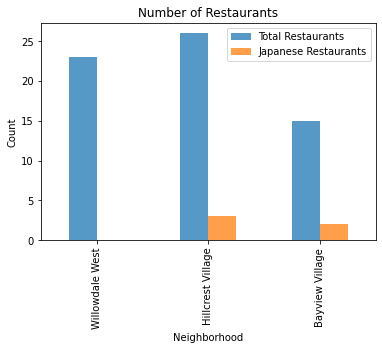

In [275]:

%matplotlib inline

ax = cluster.plot(x='Neighborhood',y=['Total Restaurants','Japanese Restaurants'],kind='bar',alpha=0.75,title='Number of Restaurants')
ax.set_ylabel('Count')

Text(0, 0.5, ' Spending Power ($)')

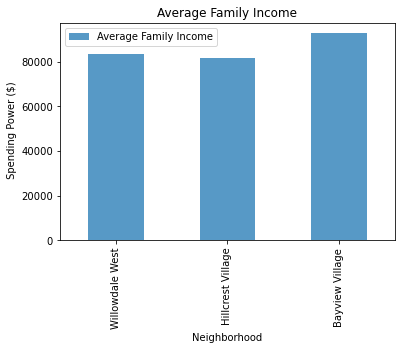

In [276]:

ax = cluster.plot(x='Neighborhood',y=['Average Family Income'],kind='bar',alpha=0.75,title='Average Family Income')
ax.set_ylabel(' Spending Power ($)')

Text(0, 0.5, 'Population')

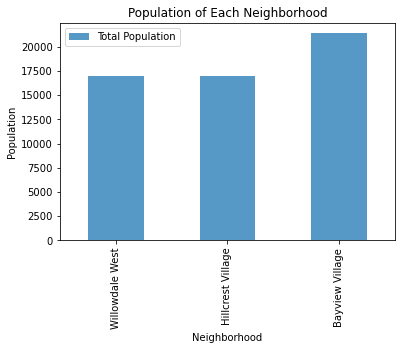

In [284]:
ax = cluster.plot(x='Neighborhood',y=['Total Population'],kind='bar',alpha=0.75,title='Population of Each Neighborhood')
ax.set_ylabel('Population')

In [294]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster,res,ires,sp in zip(cluster['Latitude'], cluster['Longitude'], cluster['Neighborhood'], cluster['Cluster Labels'],cluster['Total Restaurants'],cluster['Japanese Restaurants'],cluster['Average Family Income']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster) + '\nRestaurants: '+str(res) + '\nJapanese Restaurants: '+str(ires) +'\nSpending: '+str(sp), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-2],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Discussion

#### 
From the results of the clustering algorithm, it was determined that neighborhoods corresponding to cluster 1 were the best choice for opening an Japanese restaurant based on the  spending power and population. This narrowed down possible locations to two different areas. Using the results in map above, Willowdale West and Hillcrest Village were eliminated due to the large number of restaurants in the area.

From the two remaining regions, I would recommend that the client open his/her restaurant in either. Both regions have very few restaurants and are farther away from the downtown area. Both have a higher spending power and populatio but Willowdale region has a higher percentage of Japanese and thus the optimal region to open the Japanese Restaurant.